# Practical Implementation of Traveling Salesman Problem and its Variations

The key idea to take away from the TSP model is not that we can solve
gigantic instances with it (specialized algorithms will do much better - see [here](www.math.uwaterloo.ca/tsp/concorde.html)).

_The key idea is that, even if the number of constraints to completely specify a correct model is large, it may be possible to include a very small fraction of the for instance required constraints and yet solve the problem to optimality. To do this effectively, one must have a deep understanding of the problem and good practical modeling skills (and of course, a good modeling language and library, such as Python and Google OR-Tools)._

### OR-Tools Utility Functions

In [1]:
from ortools.linear_solver import pywraplp

def newSolver(name):
    return pywraplp.Solver(name, pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

def SolVal(x):
    if type(x) is not list:
        return 0 if x is None \
    else x if isinstance(x,(int,float)) \
        else x.SolutionValue() if x.Integer() is False \
            else int(x.SolutionValue())
    elif type(x) is list:
        return [SolVal(e) for e in x]

def ObjVal(x):
    return x.Objective().Value()

## Main TSP Algorithm 

In [2]:
import random
from random import randint,uniform
from math import sqrt

def dist(p1,p2):
    return int(round(10*sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)))


def gen_data(n):
    '''
    Example return of:     `R,points=gen_data(5)`

    R: 

        [[None, 365, 633, 486, 378],
         [318, None, 973, 794, 245],
         [540, 908, None, 395, 929],
         [500, 792, 368, None, 534],
         [400, 264, 859, 603, None]]

    points:

        [(48, 64), (29, 92), (76, 9), (33, 17), (6, 74)]
    '''
    points=[(randint(1,100), randint(1,100)) for i in range(n)]
    R=[[None for i in range(n)] for j in range(n)]
    for i in range(n):
        for j in range(n):
            perturb = uniform(0.8,1.2)
            if i != j and perturb>0:
                R[i][j]=int(dist(points[i],points[j]) * perturb)
    return R,points

#from my_or_tools import ObjVal, SolVal, newSolver

def solve_model_eliminate(D,Subtours=[]):
    s,n = newSolver('TSP'),len(D)
    x = [[s.IntVar(0,0 if D[i][j] is None else 1,'') \
          for j in range(n)] for i in range(n)] 
    for i in range(n):
        s.Add(1 == sum(x[i][j] for j in range(n)))
        s.Add(1 == sum(x[j][i] for j in range(n))) 
        s.Add(0 == x[i][i])
    for sub in Subtours:
        K = [x[sub[i]][sub[j]]+x[sub[j]][sub[i]]\
             for i in range(len(sub)-1) for j in range(i+1,len(sub))]
        s.Add(len(sub)-1 >= sum(K))
    s.Minimize(s.Sum(x[i][j]*(0 if D[i][j] is None else D[i][j]) \
                     for i in range(n) for j in range(n))) 
    rc = s.Solve()
    tours = extract_tours(SolVal(x),n) 
    return rc,ObjVal(s),tours

def extract_tours(R,n):
    node,tours,allnodes = 0,[[0]],[0]+[1]*(n-1)
    while sum(allnodes) > 0:
        next = [i for i in range(n) if R[node][i]==1][0]
        if next not in tours[-1]:
            tours[-1].append(next)
            node = next
        else:
            node = allnodes.index(1)
            tours.append([node])
        allnodes[node] = 0
    return tours

def solve_model(D):
    subtours,tours = [],[]
    subtour_iterations = []
    while len(tours) != 1:
        rc,Value,tours=solve_model_eliminate(D,subtours)
        if rc == 0:
            subtours.extend(tours)
            subtour_iterations.append(tours)
    return rc,Value,tours[0],subtours,subtour_iterations[:-1]

## Generate Random Seeded Data

In [3]:
random.seed(5)
R, points = gen_data(30)
print('R: \n%s\n' %R)
print('Points: \n%s' %points)

R: 
[[None, 298, 170, 738, 317, 710, 421, 153, 704, 459, 532, 697, 726, 744, 633, 360, 409, 126, 392, 253, 587, 727, 677, 411, 521, 493, 336, 472, 650, 936], [266, None, 58, 789, 278, 719, 832, 535, 923, 426, 944, 820, 808, 709, 974, 228, 500, 363, 485, 118, 535, 888, 1242, 507, 912, 929, 483, 741, 754, 912], [181, 71, None, 830, 419, 944, 871, 390, 1006, 502, 764, 725, 777, 628, 842, 304, 535, 336, 529, 53, 543, 768, 1160, 614, 729, 822, 496, 655, 928, 1027], [625, 981, 771, None, 1038, 1019, 451, 626, 264, 531, 645, 853, 613, 438, 303, 1176, 597, 617, 481, 884, 970, 512, 392, 355, 242, 375, 940, 344, 799, 1059], [290, 380, 411, 928, None, 578, 682, 352, 1139, 745, 556, 515, 646, 1074, 902, 253, 594, 355, 779, 430, 314, 809, 1039, 523, 929, 621, 169, 554, 590, 541], [604, 681, 816, 901, 555, None, 410, 678, 717, 979, 133, 107, 245, 1334, 671, 622, 1099, 562, 1105, 819, 185, 641, 859, 749, 1192, 635, 361, 596, 217, 116], [621, 918, 763, 462, 723, 367, None, 348, 471, 595, 329, 402, 182

## Call Solver and Clock Speed

In [4]:
import time

start = time.time()

rc,Value,tour,subtours,subtour_iterations = solve_model(R)

end = time.time()

print("Time to solve: %s seconds" %(end - start))

Time to solve: 0.824000120163 seconds


## Plot Sub-tours that are gathered as we iteratively solve for TSP

Iteration 0: 
	[0, 7, 17]
	[1, 2, 19]
	[3, 8]
	[4, 15]
	[5, 29]
	[6, 21, 25]
	[9, 18, 16]
	[10, 11]
	[12, 28]
	[13, 24]
	[14, 22]
	[20, 26]
	[23, 27]


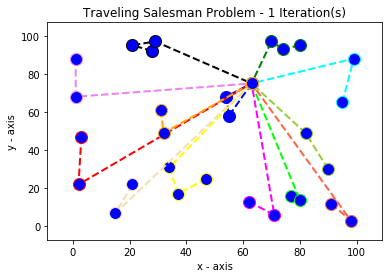

Iteration 1: 
	[0, 17]
	[1, 15]
	[2, 19]
	[3, 24]
	[4, 26]
	[5, 20, 29]
	[6, 21]
	[7, 27, 23]
	[8, 22]
	[9, 16]
	[10, 11, 28, 12]
	[13, 18]
	[14, 25]


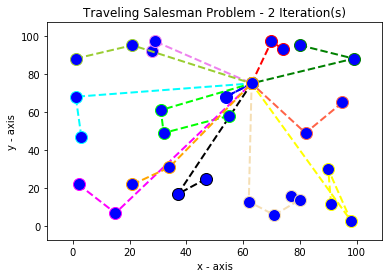

Iteration 2: 
	[0, 17, 7, 27, 23, 24, 3, 8, 22, 14, 25, 21, 6, 12, 28, 10, 11, 29, 5, 20, 26, 4, 15, 1, 2, 19]
	[9, 16, 13, 18]


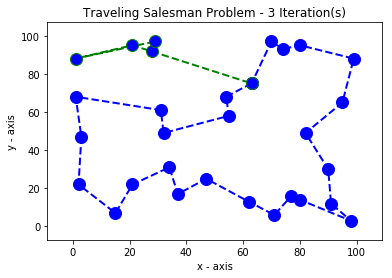

In [5]:
import matplotlib.pyplot as plt 

color_dict = {
    0: 'blue',
    1: 'green',
    2: 'red',
    3: 'cyan',
    4: 'tomato',
    5: 'yellow',
    6: 'black',
    7: 'lime',
    8: 'magenta',
    9: 'violet',
    10: 'wheat',
    11: 'yellowgreen',
    12: 'orange',
    13: 'orangered',
    14: 'ivory'
}

xmin,xmax,ymin,ymax = 5000,0,5000,0
for it,iteration in enumerate(subtour_iterations):
    print('Iteration %s: ' %it)
    for i in iteration: print("\t%s"%i)
    for c,st in enumerate(iteration):
        x,y = [],[]
        for p in st:
            x.append(points[p][0]) # x axis values 
            y.append(points[p][1]) # corresponding y axis values
        x.append(points[tour[0]][0])
        y.append(points[tour[0]][1])
        xmin = min(xmin,min(x))
        xmax = max(xmax,max(x))
        ymin = min(ymin,min(y))
        ymax = max(ymax,max(y))
        # plotting the points  
        # naming the x axis 
        plt.xlabel('x - axis') 
        # naming the y axis 
        plt.ylabel('y - axis') 
            # setting x and y axis range 
        padding = 10
        plt.xlim(xmin-padding,xmax+padding) 
        plt.ylim(ymin-padding,ymax+padding) 
        # giving a title to my graph 
        plt.title('Traveling Salesman Problem - %s Iteration(s)' %str(it+1))
        plt.plot(x, y, color=color_dict[c], linestyle='dashed', linewidth = 2,
                 marker='o', markerfacecolor='blue', markersize=12) 

    # function to show the plot 
    plt.figure(figsize=(15,8))
    plt.show() 

## Final Solution
 - Sketch of solution
 - List of cycle
 - Value

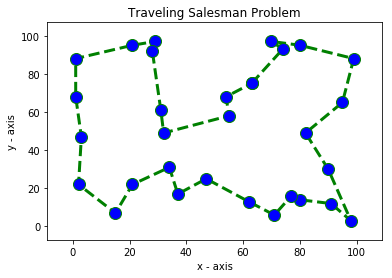

Tour: [0, 2, 19, 1, 15, 4, 26, 20, 29, 5, 11, 10, 28, 12, 6, 21, 25, 14, 22, 8, 3, 24, 13, 18, 16, 9, 23, 27, 7, 17]
Value: 4758.0


In [6]:
x,y = [],[]
for p in tour:
    x.append(points[p][0]) # x axis values 
    y.append(points[p][1]) # corresponding y axis values
x.append(points[tour[0]][0])
y.append(points[tour[0]][1])
# plotting the points  
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=12) 
# setting x and y axis range 
padding = 10
plt.xlim(min(x)-padding,max(x)+padding) 
plt.ylim(min(y)-padding,max(y)+padding) 
# naming the x axis 
plt.xlabel('x - axis') 
# naming the y axis 
plt.ylabel('y - axis') 
# giving a title to my graph 
plt.title('Traveling Salesman Problem') 
# function to show the plot 
plt.show() 
print('Tour: %s' %tour)
print('Value: %s' %Value)